<a href="https://colab.research.google.com/github/maheshr24/Paddy-Cultivation/blob/main/Satellite_based_Rice_Crop_Yield_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# Importing datasets
data1 = pd.read_csv('/content/Crop_Yield_Data_challenge_2.csv')
data2 = pd.read_csv('/content/ndvi.csv')
data3 = pd.read_csv('/content/Sentinel_1 (1).csv')
data4 = pd.read_csv('/content/Weather_Data.csv')
data4 = data4.drop(['Lattitude', 'Longtitude', 'Season'], axis=1)

In [6]:
data = pd.concat([data1, data2, data3, data4], axis=1)
data.columns

Index(['District', 'Latitude', 'Longitude',
       'Season(SA = Summer Autumn, WS = Winter Spring)',
       'Rice Crop Intensity(D=Double, T=Triple)', 'Date of Harvest',
       'Field size (ha)', 'Rice Yield (kg/ha)', 'ndvi', 'min_vh',
       ...
       'Sunlight duration section 5', 'Sunlight duration section 6',
       'Sunlight duration section 7', 'Sunlight duration section 8',
       'Sunlight duration section 9', 'Sunlight duration section 10',
       'Sunlight duration section 11', 'Sunlight duration section 12',
       'Sunlight duration section 13', 'Sunlight duration section 14'],
      dtype='object', length=231)

In [7]:
data = pd.get_dummies(data, columns=['District'])
data = pd.get_dummies(data, columns=['Season(SA = Summer Autumn, WS = Winter Spring)'])
data = pd.get_dummies(data, columns=['Rice Crop Intensity(D=Double, T=Triple)'])

In [8]:
import pandas as pd

data['Date of Harvest'] = pd.to_datetime(data['Date of Harvest'], format='%d-%m-%Y')

# Create new features
data['Year'] = data['Date of Harvest'].dt.year
data['Quarter'] = data['Date of Harvest'].dt.quarter
data['Month'] = data['Date of Harvest'].dt.month
data['Day of Year'] = data['Date of Harvest'].dt.dayofyear
data['Day of Month'] = data['Date of Harvest'].dt.day
data['Day of Week'] = data['Date of Harvest'].dt.dayofweek
data['Week of Year'] = data['Date of Harvest'].dt.isocalendar().week

# Now drop the 'Date of Harvest' column
data = data.drop(columns=['Date of Harvest'])

In [10]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [12]:
print(data.isnull().sum())

Latitude               0
Longitude              0
Field size (ha)        0
Rice Yield (kg/ha)     0
ndvi                  13
                      ..
Month                  0
Day of Year            0
Day of Month           0
Day of Week            0
Week of Year           0
Length: 241, dtype: int64


In [13]:
# Perform KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(data)
# Replace df with the imputed data
df = pd.DataFrame(df_imputed, columns=data.columns)


# Split the dataset into features and target variable
X = df.drop('Rice Yield (kg/ha)', axis=1)  # replace with your target column name
y = df['Rice Yield (kg/ha)']  # replace with your target column name

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Create a pipeline - Scale the data and then apply KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])


# Define the grid of hyperparameters
grid = {
    'knn__n_neighbors': range(1, 30),
    'knn__weights': ['uniform', 'distance']
}


# Perform Grid Search
grid_cv = GridSearchCV(pipe, grid, cv=5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(1, 30),
                         'knn__weights': ['uniform', 'distance']})

In [16]:
# Best hyperparameters
print("Best Parameters: ", grid_cv.best_params_)

Best Parameters:  {'knn__n_neighbors': 14, 'knn__weights': 'uniform'}


In [18]:
# Predict on the test set
y_pred = grid_cv.predict(X_test)

In [19]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

RMSE:  499.4431483710738


In [20]:
# Add predicted values back into the original dataframe
data.loc[X_test.index, 'Predicted Yield'] = y_pred

print(data)

      Latitude   Longitude  Field size (ha)  Rice Yield (kg/ha)      ndvi  \
0    10.510542  105.248554             3.40                5500  0.078939   
1    10.509150  105.265098             2.43                6000  0.012374   
2    10.467721  105.192464             1.95                6400  0.186522   
3    10.494453  105.241281             4.30                6000  0.106439   
4    10.535058  105.252744             3.30                6400  0.417298   
..         ...         ...              ...                 ...       ...   
552  10.364419  105.164984             7.80                6640       NaN   
553  10.358094  105.189541             2.00                7200       NaN   
554  10.368014  105.238516             6.20                7200       NaN   
555  10.275419  105.234563             3.00                6400       NaN   
556  10.304295  105.270460             2.30                7200       NaN   

       min_vh    min_vv    max_vh    max_vv  range_vh  ...  \
0    0.024129

In [22]:
# Fit the model to the entire data
grid_cv.fit(X, y)

# Predict on the entire dataset
y_pred_all = grid_cv.predict(X)

# Add predicted values back into the original dataframe
data['Predicted Yield'] = y_pred_all

print(data)

      Latitude   Longitude  Field size (ha)  Rice Yield (kg/ha)      ndvi  \
0    10.510542  105.248554             3.40                5500  0.078939   
1    10.509150  105.265098             2.43                6000  0.012374   
2    10.467721  105.192464             1.95                6400  0.186522   
3    10.494453  105.241281             4.30                6000  0.106439   
4    10.535058  105.252744             3.30                6400  0.417298   
..         ...         ...              ...                 ...       ...   
552  10.364419  105.164984             7.80                6640       NaN   
553  10.358094  105.189541             2.00                7200       NaN   
554  10.368014  105.238516             6.20                7200       NaN   
555  10.275419  105.234563             3.00                6400       NaN   
556  10.304295  105.270460             2.30                7200       NaN   

       min_vh    min_vv    max_vh    max_vv  range_vh  ...  \
0    0.024129

In [23]:
print(data.isnull().sum())

Latitude               0
Longitude              0
Field size (ha)        0
Rice Yield (kg/ha)     0
ndvi                  13
                      ..
Day of Year            0
Day of Month           0
Day of Week            0
Week of Year           0
Predicted Yield        0
Length: 242, dtype: int64


In [24]:
# Perform KNN Imputation for 'ndvi'
imputer = KNNImputer(n_neighbors=5)
data['ndvi'] = imputer.fit_transform(data[['ndvi']])
print(data.isnull().sum())

Latitude              0
Longitude             0
Field size (ha)       0
Rice Yield (kg/ha)    0
ndvi                  0
                     ..
Day of Year           0
Day of Month          0
Day of Week           0
Week of Year          0
Predicted Yield       0
Length: 242, dtype: int64


In [26]:

from sklearn.model_selection import train_test_split

# Assuming your input data is in df and target variable is 'Rice Yield (kg/ha)'
X = df.drop(columns=['Rice Yield (kg/ha)'])
y = df['Rice Yield (kg/ha)']

# 70% of data for training, 15% for validation, 15% for testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X

,Latitude,Longitude,Field size (ha),ndvi,min_vh,min_vv,max_vh,max_vv,range_vh,range_vv,...,"Season(SA = Summer Autumn, WS = Winter Spring)_WS","Rice Crop Intensity(D=Double, T=Triple)_D","Rice Crop Intensity(D=Double, T=Triple)_T",Year,Quarter,Month,Day of Year,Day of Month,Day of Week,Week of Year
0,10.510542,105.248554,3.40,0.078939,0.024129,0.005246,0.357296,0.059441,0.333167,0.054196,...,0.0,0.0,1.0,2022.0,3.0,7.0,196.0,15.0,4.0,28.0
1,10.509150,105.265098,2.43,0.012374,0.053835,0.016737,0.448553,0.136669,0.394718,0.119932,...,0.0,0.0,1.0,2022.0,3.0,7.0,196.0,15.0,4.0,28.0
2,10.467721,105.192464,1.95,0.186522,0.016936,0.010781,0.424133,0.114186,0.407197,0.103404,...,0.0,1.0,0.0,2022.0,3.0,7.0,196.0,15.0,4.0,28.0
3,10.494453,105.241281,4.30,0.106439,0.027307,0.003393,0.335494,0.070942,0.308188,0.067549,...,0.0,0.0,1.0,2022.0,3.0,7.0,196.0,15.0,4.0,28.0
4,10.535058,105.252744,3.30,0.417298,0.021431,0.004080,0.226502,0.089368,0.205071,0.085289,...,0.0,1.0,0.0,2022.0,3.0,7.0,195.0,14.0,3.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,10.364419,105.164984,7.80,0.199340,0.007758,0.002246,0.447422,0.092458,0.439664,0.090212,...,1.0,0.0,1.0,2022.0,2.0,4.0,102.0,12.0,1.0,15.0
553,10.358094,105.189541,2.00,0.123657,0.023660,0.003157,0.255528,0.080506,0.231868,0.077349,...,1.0,0.0,1.0,2022.0,2.0,4.0,102.0,12.0,1.0,15.0
554,10.368014,105.238516,6.20,0.132973,0.008751,0.002891,0.387613,0.155461,0.378862,0.152571,...,1.0,0.0,1.0,2022.0,2.0,4.0,102.0,12.0,1.0,15.0
555,10.275419,105.234563,3.00,0.098783,0.019068,0.001930,0.488400,0.097946,0.469332,0.096017,...,1.0,0.0,1.0,2022.0,2.0,4.0,110.0,20.0,2.0,16.0


In [27]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the random forest regression model
rf_model = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters: ", best_params)
# Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


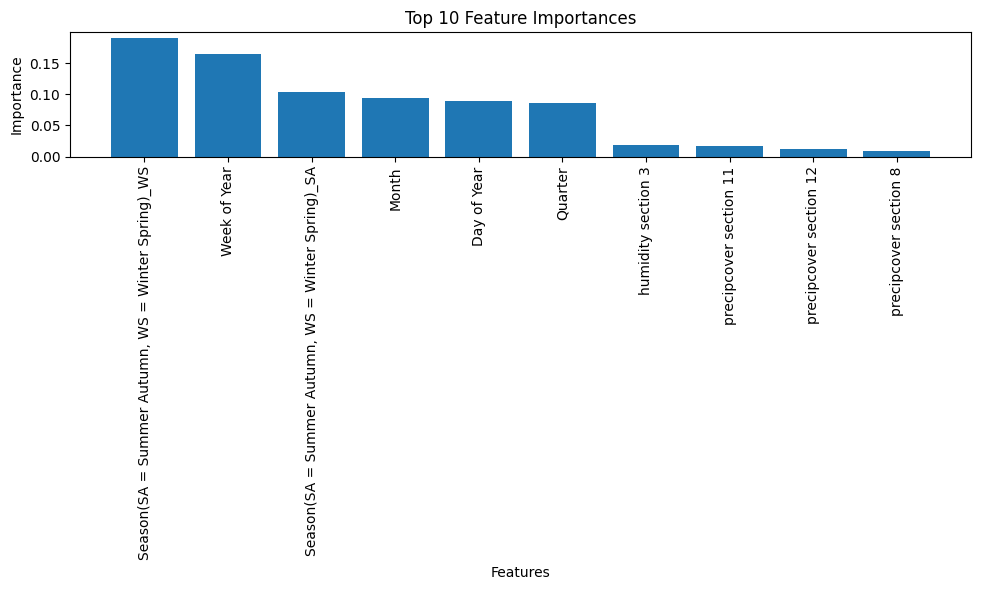

In [34]:
import matplotlib.pyplot as plt

# Assuming rf_model is the trained random forest regression model
importances = best_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Sort feature importances in descending order and get the indices of the top 10 features
top_indices = np.argsort(importances)[::-1][:10]

# Get the top 10 feature importances and feature names
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), top_importances)
plt.xticks(range(10), top_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


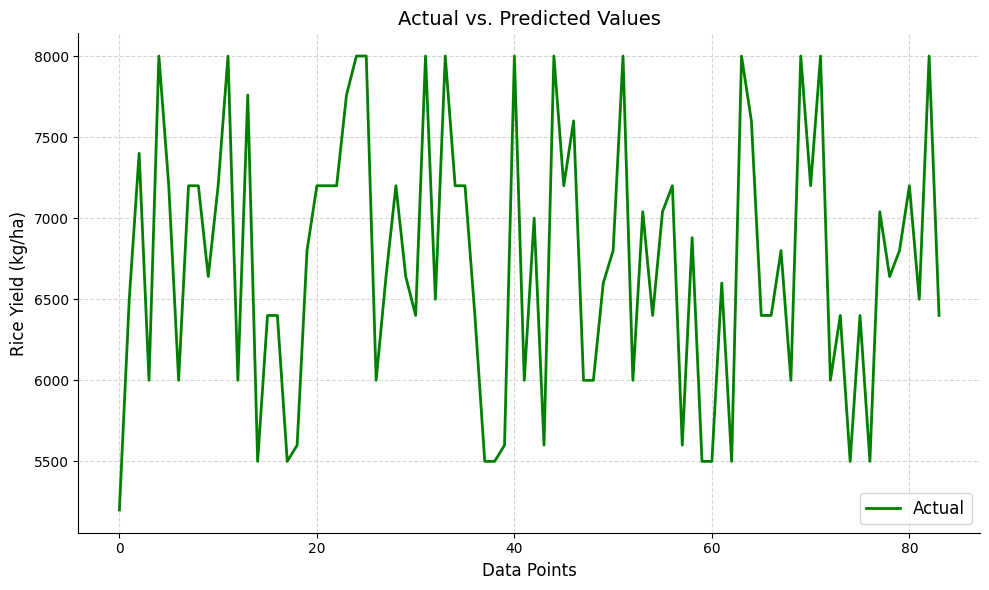

In [38]:
import matplotlib.pyplot as plt

# Assuming y_pred_rf_test and y_test are the predicted and actual values, respectively
plt.figure(figsize=(10, 6))

# Plotting the predicted values in yellow
#plt.plot(range(len(y_pred_all)), y_pred_all, label='Predicted', color='red', linewidth=2)

# Plotting the actual values in red
plt.plot(range(len(y_test)), y_test, label='Actual', color='green', linewidth=2)

# Customizing the plot
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Rice Yield (kg/ha)', fontsize=12)
plt.title('Actual vs. Predicted Values', fontsize=14)
plt.legend(fontsize=12)

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Removing top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

In [39]:

# from sklearn.model_selection import train_test_split

# # Assuming your input data is in df and target variable is 'Rice Yield (kg/ha)'
# X = df.drop(columns=['Rice Yield (kg/ha)'])
# y = df['Rice Yield (kg/ha)']

# # 70% of data for training, 15% for validation, 15% for testing
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [40]:

# Initialize the Extra Trees regression model
et_model = ExtraTreesRegressor()


# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=et_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [41]:

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


# Print the best parameters
print("Best Parameters: ", best_params)
# Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [43]:
# --------------Rabnom_Forest--------------------
print('--------------Random Forest--------------------')
from sklearn.metrics import r2_score
print('Random Forest Alone')
from sklearn.ensemble import RandomForestRegressor

# Initialize the random forest regression model with the best parameters
best_rf_model = RandomForestRegressor(max_depth=5, n_estimators=100)

# Fit the model with the best parameters using the entire training dataset
best_rf_model.fit(X_train, y_train)

# Predict on validation data with the random forest regression model
y_pred_rf_val = best_rf_model.predict(X_val)

# Calculate RMSE and R^2 for the validation data
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
r2_val_rf = r2_score(y_val, y_pred_rf_val)
print("Validation RMSE (Random Forest): ", rmse_val_rf)
print("Validation R^2 (Random Forest): ", r2_val_rf)

# Predict on test data with the random forest regression model
y_pred_rf_test = best_rf_model.predict(X_test)

# Calculate RMSE and R^2 for the test data
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
r2_test_rf = r2_score(y_test, y_pred_rf_test)
print("Test RMSE (Random Forest): ", rmse_test_rf)
print("Test R^2 (Random Forest): ", r2_test_rf)


# ---------------------EXTRA_TREES----------------------
print('---------------------EXTRA_TREES----------------------')
# Calculate RMSE and R^2 for the validation data
rmse_val_et = np.sqrt(mean_squared_error(y_val, y_pred_et_val))
r2_val_et = r2_score(y_val, y_pred_et_val)
print("Validation RMSE (Extra Trees): ", rmse_val_et)
print("Validation R^2 (Extra Trees): ", r2_val_et)

# Predict on the test data with the best model
y_pred_et_test = best_model.predict(X_test)

# Calculate RMSE and R^2 for the test data
rmse_test_et = np.sqrt(mean_squared_error(y_test, y_pred_et_test))
r2_test_et = r2_score(y_test, y_pred_et_test)
print("Test RMSE (Extra Trees): ", rmse_test_et)
print("Test R^2 (Extra Trees): ", r2_test_et)


--------------Random Forest--------------------
Random Forest Alone
Validation RMSE (Random Forest):  375.46863145735307
Validation R^2 (Random Forest):  0.7395413613951329
Test RMSE (Random Forest):  426.5431865165895
Test R^2 (Random Forest):  0.7283298666859781
---------------------EXTRA_TREES----------------------
Validation RMSE (Extra Trees):  390.3990734363901
Validation R^2 (Extra Trees):  0.7184153325945878
Test RMSE (Extra Trees):  450.1395692551117
Test R^2 (Extra Trees):  0.6974408720115497


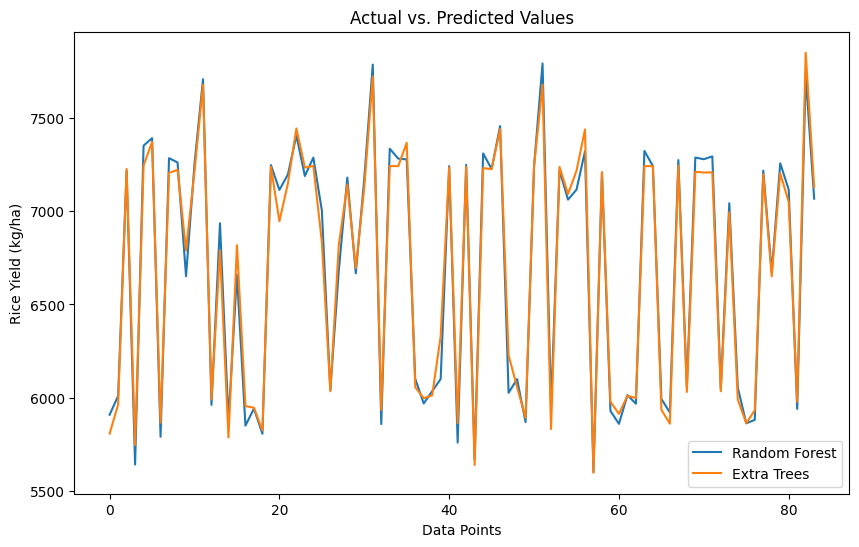

In [44]:

import matplotlib.pyplot as plt

# Assuming y_test, y_pred_rf_test, and y_pred_et_test are the actual, predicted values from Random Forest, and predicted values from Extra Trees, respectively
plt.figure(figsize=(10, 6))
# plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_pred_rf_test)), y_pred_rf_test, label='Random Forest')
plt.plot(range(len(y_pred_et_test)), y_pred_et_test, label='Extra Trees')
plt.xlabel('Data Points')
plt.ylabel('Rice Yield (kg/ha)')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()
